<a href="https://colab.research.google.com/github/nrkfeller/YCBS258/blob/master/DSDT_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q pyyaml

In [2]:
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Double check with Python 3


In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, Flatten

print(tf.VERSION)
print(tf.keras.__version__)

1.13.0-rc1
2.2.4-tf


## Models types
### Sequential
Simple stack of layers
### Functional
Multi input, multi output, shared layers, non sequential flows
### Model Subclassing
Customizable, define foward pass with ```call``` method. Enables [eager execution](https://www.tensorflow.org/guide/eager#build_a_model)

In [0]:
import numpy as np

features = np.random.random((1000, 32))
labels = np.random.random((1000, 10))

In [4]:
# maximum simplicity
seq_model = Sequential()
seq_model.add(Dense(20, activation='relu', input_shape=(32,)))
seq_model.add(Dense(20, activation='relu'))
seq_model.add(Dense(10, activation='softmax'))

seq_model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

seq_model.fit(features, labels, epochs=10, batch_size=32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 0s 108us/sample - loss: 11.7163 - acc: 0.0910
Epoch 2/10
1000/1000 [==============================] - 0s 39us/sample - loss: 11.6189 - acc: 0.0990
Epoch 3/10
1000/1000 [==============================] - 0s 40us/sample - loss: 11.6105 - acc: 0.0880
Epoch 4/10
1000/1000 [==============================] - 0s 39us/sample - loss: 11.6060 - acc: 0.0930
Epoch 5/10
1000/1000 [==============================] - 0s 40us/sample - loss: 11.6032 - acc: 0.0870
Epoch 6/10
1000/1000 [==============================] - 0s 38us/sample - loss: 11.6013 - acc: 0.0830
Epoch 7/10
1000/1000 [==============================] - 0s 39us/sample - loss: 11.5995 - acc: 0.1000
Epoch 8/10
1000/1000 [==============================] - 0s 39us/sample - loss: 11.5980 - acc: 0.1130
Epoch 9/10
1000/1000 [==============================] - 0s 41us/sample 

In [5]:
# more full featured and flexible
inputs = keras.Input(shape=(32,))
x = Dense(20, activation='relu')(inputs)
x = Dense(20, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

func_model = keras.Model(inputs, outputs)
func_model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
func_model.fit(features, labels, epochs=10, batch_size=32)

Epoch 1/10
1000/1000 [==============================] - 0s 112us/sample - loss: 11.6726 - acc: 0.0980
Epoch 2/10
1000/1000 [==============================] - 0s 41us/sample - loss: 11.6107 - acc: 0.1160
Epoch 3/10
1000/1000 [==============================] - 0s 40us/sample - loss: 11.6038 - acc: 0.1130
Epoch 4/10
1000/1000 [==============================] - 0s 39us/sample - loss: 11.6007 - acc: 0.1070
Epoch 5/10
1000/1000 [==============================] - 0s 40us/sample - loss: 11.5992 - acc: 0.1120
Epoch 6/10
1000/1000 [==============================] - 0s 41us/sample - loss: 11.5979 - acc: 0.1120
Epoch 7/10
1000/1000 [==============================] - 0s 41us/sample - loss: 11.5968 - acc: 0.1160
Epoch 8/10
1000/1000 [==============================] - 0s 41us/sample - loss: 11.5960 - acc: 0.1210
Epoch 9/10
1000/1000 [==============================] - 0s 42us/sample - loss: 11.5949 - acc: 0.1190
Epoch 10/10
1000/1000 [==============================] - 0s 39us/sample - loss: 11.5941 - 

In [6]:
# maximally flexible and hackable
class ScModel(keras.Model):
  
  def __init__(self):
    super(ScModel, self).__init__()
    self.dense1 = Dense(20, activation='relu')
    self.dense2 = Dense(20, activation='relu')
    self.dense3 = Dense(10, activation='softmax')
    
  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    return self.dense3(x)
  
sc_model = ScModel()
sc_model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
sc_model.fit(features, labels, epochs=10, batch_size=32)

Epoch 1/10
1000/1000 [==============================] - 0s 120us/sample - loss: 11.6712 - acc: 0.0890
Epoch 2/10
1000/1000 [==============================] - 0s 41us/sample - loss: 11.6203 - acc: 0.0930
Epoch 3/10
1000/1000 [==============================] - 0s 41us/sample - loss: 11.6082 - acc: 0.0910
Epoch 4/10
1000/1000 [==============================] - 0s 44us/sample - loss: 11.6038 - acc: 0.0850
Epoch 5/10
1000/1000 [==============================] - 0s 43us/sample - loss: 11.6013 - acc: 0.0860
Epoch 6/10
1000/1000 [==============================] - 0s 40us/sample - loss: 11.5995 - acc: 0.0870
Epoch 7/10
1000/1000 [==============================] - 0s 42us/sample - loss: 11.5985 - acc: 0.0900
Epoch 8/10
1000/1000 [==============================] - 0s 41us/sample - loss: 11.5971 - acc: 0.0960
Epoch 9/10
1000/1000 [==============================] - 0s 42us/sample - loss: 11.5959 - acc: 0.1060
Epoch 10/10
1000/1000 [==============================] - 0s 42us/sample - loss: 11.5948 - 

## Visualize model

The summary is useful for simple models, but can be confusing for models that have multiple inputs or outputs.

Keras also provides a function to create a plot of the network neural network graph that can make more complex models easier to understand.

The plot_model() function in Keras will create a plot of your network. This function takes a few useful arguments:

* ```model```: (required) The model that you wish to plot.
* ```to_file```: (required) The name of the file to which to save the plot.
* ```show_shapes```: (optional, defaults to False) Whether or not to show the output shapes of each layer.
* ```show_layer_names```: (optional, defaults to True) Whether or not to show the name for each layer.

In [64]:
seq_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                660       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 1,290
Trainable params: 1,290
Non-trainable params: 0
_________________________________________________________________


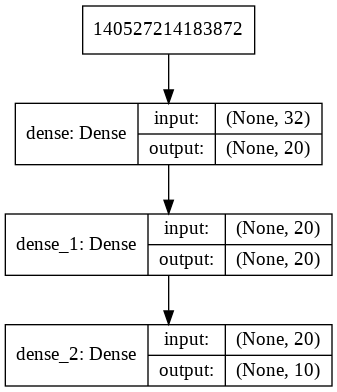

In [60]:
mod = seq_model

tf.keras.utils.plot_model(
    mod, 
    to_file='{}.png'.format(mod), 
    show_shapes=True, 
    show_layer_names=True
)

from IPython.display import Image
Image(retina=True, filename='{}.png'.format(mod))

### Evaluate and predict

The `tf.keras.Model.evaluate` and `tf.keras.Model.predict` methods can use NumPy
data and a `tf.data.Dataset`.

To *evaluate* the inference-mode loss and metrics for the data provided:

In [0]:
# Unseen data
new_data  = np.random.random((1000, 32))
new_labels = np.random.random((1000, 10))

In [18]:
results = sc_model.predict(new_data)
result[0]

array([0.10206428, 0.10225593, 0.10290581, 0.09177212, 0.09711654,
       0.10257207, 0.10409451, 0.09810156, 0.09766256, 0.10145466],
      dtype=float32)

In [16]:
sc_model.evaluate(new_data, new_labels)

1000/1000 [==============================] - 0s 100us/sample - loss: 11.4959 - acc: 0.1010


[11.495928741455078, 0.101]

### Input tf.data datasets

Use the Dataset API to scale to large datasets
or multi-device training. Pass a `tf.data.Dataset` instance to the `fit`
method:

Here, the `fit` method uses the `steps_per_epoch` argument—this is the number of
training steps the model runs before it moves to the next epoch. Since the
`Dataset` yields batches of data, this snippet does not require a `batch_size`.

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.batch(32)
dataset = dataset.repeat()

In [0]:
sc_model.fit(dataset, epochs=10, steps_per_epoch=30)

### Custom layers

Create a custom layer by subclassing `tf.keras.layers.Layer` and implementing
the following methods:

* `build`: Create the weights of the layer. Add weights with the `add_weight`
  method.
* `call`: Define the forward pass.
* `compute_output_shape`: Specify how to compute the output shape of the layer
  given the input shape.
* Optionally, a layer can be serialized by implementing the `get_config` method
  and the `from_config` class method.

Here's an example of a custom layer that implements a `matmul` of an input with
a kernel matrix:

In [0]:
class MyLayer(layers.Layer):

  def __init__(self, output_dim, **kwargs):
    self.output_dim = output_dim
    super(MyLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    shape = tf.TensorShape((input_shape[1], self.output_dim))
    # Create a trainable weight variable for this layer.
    self.kernel = self.add_weight(name='kernel',
                                  shape=shape,
                                  initializer='uniform',
                                  trainable=True)
    # Make sure to call the `build` method at the end
    super(MyLayer, self).build(input_shape)

  def call(self, inputs):
    return tf.matmul(inputs, self.kernel)

  def compute_output_shape(self, input_shape):
    shape = tf.TensorShape(input_shape).as_list()
    shape[-1] = self.output_dim
    return tf.TensorShape(shape)

  def get_config(self):
    base_config = super(MyLayer, self).get_config()
    base_config['output_dim'] = self.output_dim
    return base_config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [22]:
model = tf.keras.Sequential([
    MyLayer(10),
    layers.Activation('softmax')])

# The compile step specifies the training configuration
model.compile(optimizer=tf.train.RMSPropOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Trains for 5 epochs.
model.fit(features, labels, batch_size=32, epochs=5)

Epoch 1/5
1000/1000 [==============================] - 0s 113us/sample - loss: 11.6105 - acc: 0.0980
Epoch 2/5
1000/1000 [==============================] - 0s 40us/sample - loss: 11.6041 - acc: 0.0950
Epoch 3/5
1000/1000 [==============================] - 0s 40us/sample - loss: 11.6021 - acc: 0.1000
Epoch 4/5
1000/1000 [==============================] - 0s 43us/sample - loss: 11.6009 - acc: 0.0920
Epoch 5/5
1000/1000 [==============================] - 0s 39us/sample - loss: 11.5988 - acc: 0.1030


## Callbacks

A callback is an object passed to a model to customize and extend its behavior
during training. You can write your own custom callback, or use the built-in
`tf.keras.callbacks` that include:

* `tf.keras.callbacks.ModelCheckpoint`: Save checkpoints of your model at
  regular intervals.
* `tf.keras.callbacks.LearningRateScheduler`: Dynamically change the learning
  rate.
* `tf.keras.callbacks.EarlyStopping`: Interrupt training when validation
  performance has stopped improving.
* `tf.keras.callbacks.TensorBoard`: Monitor the model's behavior using
  [TensorBoard](./summaries_and_tensorboard.md).

To use a `tf.keras.callbacks.Callback`, pass it to the model's `fit` method:

In [23]:
callbacks = [
  # Interrupt training if `val_loss` stops improving for over 2 epochs
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]
model.fit(features, labels, batch_size=32, epochs=5, callbacks=callbacks,
          validation_data=(new_data, new_labels))

Train on 1000 samples, validate on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 0s 124us/sample - loss: 11.5973 - acc: 0.0990 - val_loss: 11.4942 - val_acc: 0.0990
Epoch 2/5
1000/1000 [==============================] - 0s 68us/sample - loss: 11.5961 - acc: 0.1100 - val_loss: 11.4942 - val_acc: 0.1120
Epoch 3/5
1000/1000 [==============================] - 0s 66us/sample - loss: 11.5942 - acc: 0.0960 - val_loss: 11.4968 - val_acc: 0.1160


## Model Saving and Restoring
### Weights only

Save and load the weights of a model using `tf.keras.Model.save_weights`:

### Configuration only

A model's configuration can be saved—this serializes the model architecture
without any weights. A saved configuration can recreate and initialize the same
model, even without the code that defined the original model. Keras supports
JSON and YAML serialization formats:

### Entire model

The entire model can be saved to a file that contains the weight values, the
model's configuration, and even the optimizer's configuration. This allows you
to checkpoint a model and resume training later—from the exact same
state—without access to the original code.

In [25]:
# Create a trivial model
model = tf.keras.Sequential([
  layers.Dense(10, activation='softmax', input_shape=(32,)),
  layers.Dense(10, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(features, labels, batch_size=32, epochs=5)


# Save entire model to a HDF5 file
model.save('my_model.h5')

# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('my_model.h5')

Epoch 1/5
1000/1000 [==============================] - 0s 146us/sample - loss: 11.6218 - acc: 0.1140
Epoch 2/5
1000/1000 [==============================] - 0s 41us/sample - loss: 11.6087 - acc: 0.1090
Epoch 3/5
1000/1000 [==============================] - 0s 40us/sample - loss: 11.6038 - acc: 0.1060
Epoch 4/5
1000/1000 [==============================] - 0s 42us/sample - loss: 11.6020 - acc: 0.0870
Epoch 5/5
1000/1000 [==============================] - 0s 41us/sample - loss: 11.6011 - acc: 0.1010


## Pretrained Models

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

import tensorflow.keras.backend as K
import numpy as np

In [0]:
model = ResNet50(weights='imagenet')

[imagenet classes](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

In [67]:
!wget -O test.png https://www.freepngimg.com/thumb/corn/23-corn-png-image-thumb.png
# !wget -O test.png https://vignette.wikia.nocookie.net/dino/images/f/f6/JW_triceratops.png/revision/latest?cb=20150407211112

--2019-02-18 06:41:49--  https://www.freepngimg.com/thumb/corn/23-corn-png-image-thumb.png
Resolving www.freepngimg.com (www.freepngimg.com)... 88.99.162.33
Connecting to www.freepngimg.com (www.freepngimg.com)|88.99.162.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38182 (37K) [image/png]
Saving to: ‘test.png’

test.png            100%[===================>]  37.29K  --.-KB/s    in 0.1s    

2019-02-18 06:41:50 (252 KB/s) - ‘test.png’ saved [38182/38182]



In [68]:
img_path = 'test.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n12144580', 'corn', 0.64657545), ('n13133613', 'ear', 0.3533439), ('n02226429', 'grasshopper', 2.1798884e-05)]


In [69]:
# Get the embedding form the corn picture
get_last_layer_output = K.function(
    [model.layers[0].input],
    [model.layers[-1].output]
)

get_last_layer_output([x])[0]

array([[1.81401127e-09, 2.10655600e-08, 2.01605347e-11, 8.55778122e-12,
        1.23430419e-10, 2.48004106e-09, 3.50771669e-11, 1.88458671e-09,
        4.13836951e-11, 7.38607620e-10, 7.73161424e-10, 5.92839910e-09,
        3.11844911e-10, 3.01498493e-10, 2.45025389e-10, 2.41970044e-09,
        6.93767976e-09, 7.69180097e-09, 1.91994332e-09, 2.80251489e-09,
        5.37239038e-11, 1.11471021e-09, 5.04323028e-10, 2.61362515e-10,
        1.07844129e-10, 6.23819829e-10, 7.58426988e-10, 7.21871141e-09,
        1.54841542e-10, 1.48240087e-09, 1.96636124e-10, 1.98224281e-08,
        8.18554891e-10, 2.57582376e-11, 1.00941633e-09, 1.04832594e-10,
        7.54628721e-11, 1.48931242e-10, 7.11724102e-09, 2.29515660e-08,
        3.59237120e-08, 3.78036186e-10, 7.09126491e-09, 1.21375343e-09,
        1.03039188e-09, 1.05831732e-09, 3.93287074e-08, 1.47115173e-08,
        1.50832874e-10, 1.13640916e-10, 8.41023085e-10, 1.16445120e-09,
        1.53517998e-09, 7.39865280e-10, 7.16099818e-11, 8.149220

In [70]:
# Other way to do the same thing, just create another model
temp_model = Model(
    [model.layers[0].input],
    [model.layers[-1].output]
)

temp_model.predict(x)

array([[1.81401127e-09, 2.10655600e-08, 2.01605347e-11, 8.55778122e-12,
        1.23430419e-10, 2.48004106e-09, 3.50771669e-11, 1.88458671e-09,
        4.13836951e-11, 7.38607620e-10, 7.73161424e-10, 5.92839910e-09,
        3.11844911e-10, 3.01498493e-10, 2.45025389e-10, 2.41970044e-09,
        6.93767976e-09, 7.69180097e-09, 1.91994332e-09, 2.80251489e-09,
        5.37239038e-11, 1.11471021e-09, 5.04323028e-10, 2.61362515e-10,
        1.07844129e-10, 6.23819829e-10, 7.58426988e-10, 7.21871141e-09,
        1.54841542e-10, 1.48240087e-09, 1.96636124e-10, 1.98224281e-08,
        8.18554891e-10, 2.57582376e-11, 1.00941633e-09, 1.04832594e-10,
        7.54628721e-11, 1.48931242e-10, 7.11724102e-09, 2.29515660e-08,
        3.59237120e-08, 3.78036186e-10, 7.09126491e-09, 1.21375343e-09,
        1.03039188e-09, 1.05831732e-09, 3.93287074e-08, 1.47115173e-08,
        1.50832874e-10, 1.13640916e-10, 8.41023085e-10, 1.16445120e-09,
        1.53517998e-09, 7.39865280e-10, 7.16099818e-11, 8.149220

### Fine-tuning pre-trained model
Provided that our dataset is not drastically different in context to the original dataset, we can use pretrained models like the one above to fine tune to a different task

In [71]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [72]:
# remove the softmax layer
model = Model(inputs=model.inputs, outputs=model.get_layer('avg_pool').output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [73]:
# Freeze the previous layers
for layer in model.layers[:-1]:
    layer.trainable = False

# add a couple layers
x = Flatten()(model.layers[-1].output)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(100, activation='softmax')(x)

model = Model(inputs=model.input, outputs=out)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation